In [728]:
!pip install brian2

In [729]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import ssl
import requests
import pandas as pd
from collections import Counter

defaultclock.dt = 0.022*us

'''
import brian2cuda
set_device("cuda_standalone")
'''

#Some code to fix SSL errors
requests.packages.urllib3.disable_warnings()

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

#Download the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Choose 1000 train images and 100 test images with all classes
num_train_per_class = 100
num_test_per_class = 10

# Initialize variables to store the selected indices
selected_train_indices = []
selected_test_indices = []

# Loop through each class
for class_label in range(10):  # MNIST has 10 classes (0 to 9)
    # Get indices of images with the current class label in the training set
    class_indices = np.where(y_train == class_label)[0]
    
    # Choose the first 'num_train_per_class' indices for training
    selected_train_indices.extend(class_indices[:num_train_per_class])

    # Get indices of images with the current class label in the test set
    class_indices = np.where(y_test == class_label)[0]
    
    # Choose the first 'num_test_per_class' indices for testing
    selected_test_indices.extend(class_indices[:num_test_per_class])

# Select the corresponding images and labels for training and testing
X_train = X_train[selected_train_indices]
y_train = y_train[selected_train_indices]

X_test = X_test[selected_test_indices]
y_test = y_test[selected_test_indices]

X_train = X_train/255.0
X_test = X_test/255.0


permutation_train = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation_train]
y_train = y_train[permutation_train]

permutation_test = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation_test]
y_test = y_test[permutation_test]


epoch = 1
n_input = 28*28 # input layer
n_output = 10 #output layer

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1000, 28, 28)
(1000,)
(100, 28, 28)
(100,)


In [730]:
def encode_data(X):
    num_input = X.shape[1]*X.shape[2]
    #num_input = X.shape[1]
    num_timesteps_input = X.shape[0]
    num_timesteps_per_input = 1
    data = np.zeros((num_timesteps_input, num_input))
    for i in range(X.shape[0]):
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, :] = X[i].ravel()
    return data

t_exposure = 110*us

data_training = encode_data(X_train)
data_eval_train = encode_data(X_train)
data_eval_test = encode_data(X_test)
data_stim_in = np.zeros((n_output, n_input)) #Fix if using more than 1 neuron per digit
stimulus_list = []
for ep in range(epoch):
    stimulus_list.append(data_training)
    stimulus_list.append(data_eval_train)
    stimulus_list.append(data_eval_test)
stimulus_list.append(data_stim_in)

stimulus = TimedArray(np.vstack(stimulus_list), dt = t_exposure)

In [731]:
def encode_output_stimulus(X, y):
    num_input = n_output
    num_nodes_per_input = int(n_output/10)
    #num_input = X.shape[1]
    num_timesteps_input = X.shape[0]
    num_timesteps_per_input = 1
    data = np.zeros((num_timesteps_input, num_input))
    for i in range(X.shape[0]):
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, :] = 1
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, 
        num_nodes_per_input*y[i]:num_nodes_per_input*(y[i]+1)] = 0
    return data

data_training = encode_output_stimulus(X_train, y_train)
data_eval_train = np.zeros((X_train.shape[0], n_output))
data_eval_test = np.zeros((X_test.shape[0], n_output))

data_back_stim = np.array([[1 if j == i else 0 for j in range(n_output)] for i in range(n_output)]) #Fix this if using more than 1 neuron per class
data_stim_out = np.zeros((n_output, n_output))

stimulus_train_list = []
for ep in range(epoch):
    stimulus_train_list.append(data_training)
    stimulus_train_list.append(data_eval_train)
    stimulus_train_list.append(data_eval_test)
stimulus_train_list.append(data_stim_out)
    
stimulus_back_list = []
for ep in range(epoch):
    stimulus_back_list.append(np.zeros((X_train.shape[0], n_output)))
    stimulus_back_list.append(np.zeros((X_train.shape[0], n_output)))
    stimulus_back_list.append(np.zeros((X_test.shape[0], n_output)))
stimulus_back_list.append(data_back_stim)

stimulus_train = TimedArray(np.vstack(stimulus_train_list), dt = t_exposure)
stimulus_back = TimedArray(np.vstack(stimulus_back_list), dt = t_exposure)

In [732]:
#np.savetxt('./tst.txt', data_training, fmt='%d')

In [733]:
I_max = 4*nA #Current term to convert input pixel intensities to current injections
I_inhibitory = 10*nA #Current unit term for the inhibitory connections among output neurons
I_b = -100*nA
I_back_stim = 10*nA


#LIF parameters as per Sahu et. al (2021)
gl = 30*nsiemens
el = -70*mV
C = 500e-15*farad

t_refractory = 5*us

# Neuron potenital parameters as per Sahu et. al (2021)
v_rest_in = -70.*mV #Resting membrane potential
v_reset_in = -70.*mV #Reset potential
v_thresh_in = 20.*mV #Threshold potential

v_rest_out = -70.*mV 
v_reset_out = -70.*mV
v_thresh_out = 20.*mV
vt0 = 20*mV
delta_v_thresh_out = 7.*mV #Homeostasis threshold
tauhomeo = 15*us 

#STDP related parameters as per Sahu et. al (2021)
tau1 = 10*us
tau2 = 20*us
mu = 1.7
gamma1 = 9.0
gamma2 = 15.0
w_stdp_max = 900.0
w_stdp_mean = 100
w_stdp_sd = 10

#Inhibitory synapse parameters as per Sahu et. al (2021)
#w_inhibitory_mean = -4000
#w_inhibitory_sd = 100
w_inhibitory_mean = -500
w_inhibitory_sd = 50


#Tempotron equation parameters as per Sahu et. al (2021)
tau_m = 10*us
tau_s = 2.5*us
I0 = 3e-12*amp
I0_back = 1e-11*amp


# Implement the STDP rule from Sahu et. al (2021)
stdp='''
    w : 1
    lr : 1 (shared)
    '''     
on_pre='''
        lastspike_pre = t
        delta_t = (lastspike_pre - lastspike_post)
        w -= lr*gamma2*((w/w_stdp_max)**mu)*exp(-delta_t/tau2)
        x_post += I0*w
        '''
on_post='''
        lastspike_post = t
        delta_t = (lastspike_post - lastspike_pre)
        w += lr*gamma1*((1-w/w_stdp_max)**mu)*exp(-delta_t/tau1)
        '''

on_post_back='''
            x_back_pre += I0_back*w2    
            '''



class Model():
    
    def __init__(self, debug=False):
        
        app = {}
                
        # Input group 
        neuron_input = '''
        dv/dt = (-gl*(v-el) + I_back + stimulus(t, i)*I_max)/C : volt
        dI_back/dt =  ((tau_m / tau_s-1)*x_back-I_back)/tau_m : amp
        dx_back/dt = -x_back/tau_s : amp
        '''
        
        app['InputGroup'] = NeuronGroup(n_input, neuron_input, threshold='v>v_thresh_in', refractory=t_refractory,
                                        reset='v=v_reset_in', method='euler', name='InputGroup')
        app['InputGroup'].v = v_rest_in
        
        app['InputGroup'].run_regularly("v = v_rest_in", dt = t_exposure)
        
        if (debug):
            app['ISP'] = SpikeMonitor(app['InputGroup'], name='ISP')
            app['ISM'] = StateMonitor(app['InputGroup'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['InputGroup'], name='IRM')
        
        
        #Output group
        neuron_output = '''
            dv/dt = (-gl*(v-el) + I + stimulus_train(t, i)*I_b + stimulus_back(t, i)*I_back_stim)/C : volt
            dvt/dt = (vt0-vt)/tauhomeo : volt
            dI/dt = ((tau_m / tau_s-1)*x-I)/tau_m : amp
            dx/dt = -x/tau_s                      : amp
            '''
        neuron_output_reset = '''
                            v = v_reset_out
                            vt += delta_v_thresh_out
                            '''
        app['OutputGroup'] = NeuronGroup(n_output, neuron_output, threshold='v>vt', refractory=5*us,
                                        namespace={'C': C, 'gl': gl, 'el': el, 'tauhomeo':tauhomeo},
                                        reset=neuron_output_reset, method='euler', name='OutputGroup')
        app['OutputGroup'].v = v_rest_out
        app['OutputGroup'].vt = vt0
        
        app['OutputGroup'].run_regularly("v = v_rest_out; I = 0*amp; vt = vt0; x = 0*amp", dt = t_exposure)


        if (debug):
            app['OSP'] = SpikeMonitor(app['OutputGroup'], name='OSP')
            app['OSM'] = StateMonitor(app['OutputGroup'], ['v', 'I', 'x', 'vt'], record=True, name='OSM')
            app['ORM'] = PopulationRateMonitor(app['OutputGroup'], name='ORM')
        
        # one-to all STDP connections between input and output  
        app['S1'] = Synapses(app['InputGroup'], app['OutputGroup'], stdp, on_pre=on_pre, on_post=on_post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'randn()*w_stdp_sd + w_stdp_mean' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w'], record=app['S1'][294,:4], name='S1M') 
        
        # Output neurons one-to-all-except-one connections (inhibitory)
        app['S2'] = Synapses(app['OutputGroup'], app['OutputGroup'], 'w : 1', on_pre='I_post += w*I_inhibitory', name='S2')
        app['S2'].connect(condition='i!=j')
        #app['S2'].delay = 'rand()*0.5*us'
        app['S2'].w = 'randn()*w_inhibitory_sd + w_inhibitory_mean' # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        #Synapses from output to input neurons for recapitulation
        app['S3'] = Synapses(app['InputGroup'], app['OutputGroup'], 'w2 : 1', on_post=on_post_back, method='euler', name='S3')
        app['S3'].connect()
        app['S3'].w2 = 0
        
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X_train, y_train, X_test, y_test, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        hstat_sw = 1
        
        #TO DO: Add the epoch loop, think very carefully about how simulation times will play out
        time_elapsed = 0
        train_acc_list = []
        test_acc_list = []
        for ep in range(epoch):
            #self.net['OutputGroup'].vt = vt0
            self.net.run((t_exposure)*X_train.shape[0], report = 'text', report_period = 30*second)
            time_elapsed += (t_exposure)*X_train.shape[0] 
            print('Starting the evalutation process!')
            #self.net['OutputGroup'].vt = vt0
            train_accuracy, time = self.evaluate_v2(X_train, y_train, time_elapsed)
            time_elapsed += time
            print('Train Accuracy after epoch {}: {}%'.format(ep+1, train_accuracy))
            train_acc_list.append(train_accuracy)
            #self.net['OutputGroup'].vt = vt0
            test_accuracy, time = self.evaluate_v2(X_test, y_test, time_elapsed)
            time_elapsed += time
            print('Test Accuracy after epoch {}: {}%'.format(ep+1, test_accuracy))
            test_acc_list.append(test_accuracy)
            self.net['S1'].lr = 1 #Switch on STDP after evaluating
        return train_acc_list, test_acc_list, time_elapsed

    def assign_output_labels(self, features, labels):
        num_neurons = features[0].shape[0]
        result_dict = {}

        for neuron_idx in range(num_neurons):
            neuron_spikes_by_label = Counter()

            for sample_idx, feature_vector in enumerate(features):
                spikes = feature_vector[neuron_idx]
                label = labels[sample_idx]
                neuron_spikes_by_label[label] += np.sum(spikes)

            # Find the label with the maximum spikes for this neuron
            max_label, _ = neuron_spikes_by_label.most_common(1)[0]
            result_dict[neuron_idx] = max_label

        return result_dict

    def evaluate_v2(self, X, y, time_elapsed):   
        self.net['S1'].lr = 0 
        features = []
        
        mon = SpikeMonitor(self.net['OutputGroup'], name='OutputRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*X.shape[0]
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        num_intervals = int(duration / interval_duration)
        #print(mon.spike_trains())
        #plot(mon.t/us, mon.i, '.b', label = 'out')
        for interval in range(num_intervals):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)

        self.net.remove(self.net['OutputRateMonitor'])
        
        num_correct = 0
        num_total = len(features)
        for i, spike_array in enumerate(features):
            neuron_idx = np.argmax(spike_array)
            if (neuron_idx >= y[i]*(n_output/10) and neuron_idx < (y[i]+1)*(n_output/10)):
                num_correct += 1
        return (num_correct/num_total)*100.0, duration
    
    def recapitulate(self, time_elapsed):
        #Note this does not work for more than 1 neuron per class; TO DO
        features = []
        print('Starting Recapitulation!')
        w_s1 = np.array(self.net['S1'].w)
        w_s2  = np.array(self.net['S2'].w)
        self.net['S1'].w = 0
        self.net['S1'].lr = 0
        self.net['S2'].w = 0
        self.net['S3'].w2 = w_s1
        features = []
        
        mon = SpikeMonitor(self.net['InputGroup'], name='InputRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*10
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        num_intervals = int(duration / interval_duration)
        #print(mon.spike_trains())
        #plot(mon.t/us, mon.i, '.b', label = 'out')
        for interval in range(num_intervals):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)

        self.net.remove(self.net['InputRateMonitor'])
        self.net['S1'].w = w_s1
        self.net['S1'].lr = 1
        self.net['S2'].w = w_s2
        #self.net['S3'].w = 0
        
        return features
            

In [734]:
def supervised_learning(X_train, y_train, X_test, y_test):   
    seed(69420)
    
    model = Model(debug = False)
    train_acc_list, test_acc_list, time = model.train(X_train, y_train, X_test, y_test, epoch=epoch)
    #model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    back_spikes= model.recapitulate(time)
    return model, train_acc_list, test_acc_list, back_spikes



    
model, train_acc_list, test_acc_list, back_spikes= supervised_learning(X_train, y_train, X_test, y_test)
epoch_list = np.arange(1, epoch+1)

acc_data = {
    'Epoch': epoch_list,
    'Train_Accuracy': train_acc_list,
    'Test_Accuracy': test_acc_list
}

df = pd.DataFrame(acc_data)
#df.to_csv('./results/snnmnist-supervised.csv', index=False)

Starting simulation at t=0. s for a duration of 110. ms
5.88478 ms (5%) simulated in 30s, estimated 8m 51s remaining.
11.746152 ms (10%) simulated in 1m 0s, estimated 8m 22s remaining.
17.643956 ms (16%) simulated in 1m 30s, estimated 7m 51s remaining.
23.56123 ms (21%) simulated in 2m 0s, estimated 7m 20s remaining.
29.478702 ms (26%) simulated in 2m 30s, estimated 6m 50s remaining.
35.397296 ms (32%) simulated in 3m 0s, estimated 6m 19s remaining.
41.289182 ms (37%) simulated in 3m 30s, estimated 5m 49s remaining.
47.138168 ms (42%) simulated in 4m 0s, estimated 5m 20s remaining.
53.0497 ms (48%) simulated in 4m 30s, estimated 4m 50s remaining.
58.897278 ms (53%) simulated in 5m 0s, estimated 4m 20s remaining.
64.771124 ms (58%) simulated in 5m 30s, estimated 3m 50s remaining.
70.664198 ms (64%) simulated in 6m 0s, estimated 3m 20s remaining.
76.526384 ms (69%) simulated in 6m 30s, estimated 2m 51s remaining.
82.43411 ms (74%) simulated in 7m 0s, estimated 2m 20s remaining.
88.28787 

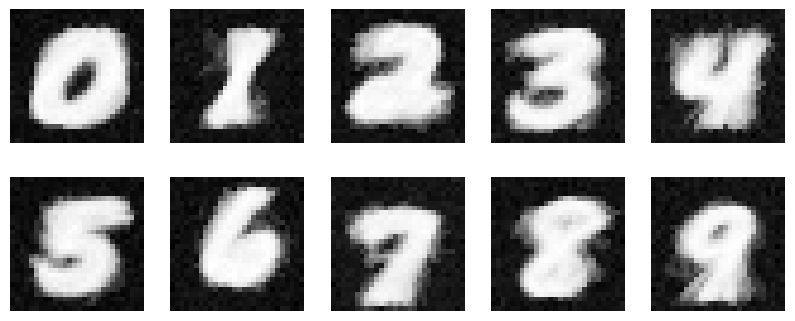

In [735]:
weights = np.array(model['S1'].w)/w_stdp_max
weights = weights.reshape(784, n_output)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = weights.T[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Hide axis labels

plt.show()

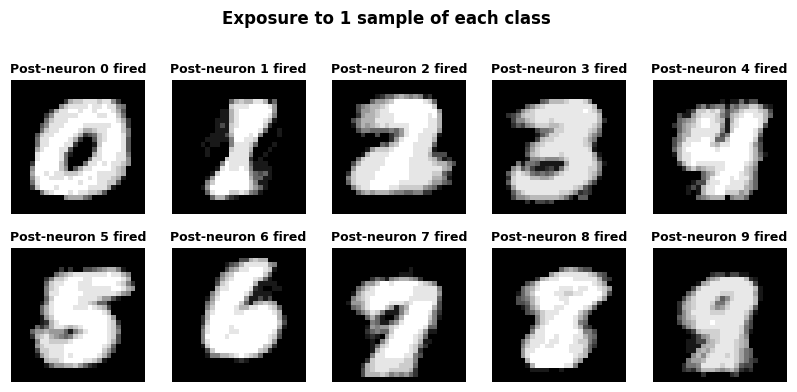

In [736]:
back_spikes = np.array(back_spikes)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = back_spikes[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Post-neuron {i} fired", fontsize=9, fontweight = 'bold',)
    ax.axis('off')  # Hide axis labels
fig.suptitle("Exposure to 1 sample of each class", fontsize=12, fontweight = 'bold', y=1.05)
plt.savefig("image.png")
plt.show()

In [737]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    plot(S1M.t/us, S1M.w.T/w_stdp_max)
    ylabel('w / wmax')
    show();
    
def plot_v(OSM, ISM, neuron=0):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ISM.t[cnt:]/us, ISM.v[neuron][cnt:]/mV, label='in', color='r')
    #ylim(-100, 30)
    xlim(3300, 3410)
    #plot(OSM.t[cnt:]/us, OSM.v[neuron][cnt:]/mV, label='out', color='b')
    #plot(OSM.t[cnt:]/us, OSM.vt[neuron][cnt:]/mV, label='out', color='pink')
    axhline(-70)
    #plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    #plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    #legend()
    ylabel('v')
    show();

def plot_i(OSM, neuron=203):
    plt.rcParams["figure.figsize"] = (20,6)
    #cnt = -50000 # tail
    plot(OSM.t/us, OSM.I[neuron]/nA, label='out', color='b')
    #plot(OSM.t/us, OSM.x[neuron]/nA, label='out', color='r')
    #plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    #plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('I')
    show();
    
def plot_rates(IRM, ORM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(IRM.t/us, IRM.smooth_rate(window='flat', width=0.1*us)*Hz, color='r')
    plot(ORM.t/us, ORM.smooth_rate(window='flat', width=0.1*us)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ISP, OSP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ISP.t/us, ISP.i, '.r', label = 'in')
    plot(OSP.t/us, OSP.i, '.b', label = 'out')
    #ylim(0, 10)
    xlim(3300, 3410)
    legend()
    ylabel('Neuron index')
    show();
    
#plot_w(model['S1M'])


    

In [738]:
#plot_v(model['OSM'], model['ISM'])

In [739]:
#plot_i(model['OSM'])

In [740]:
#plot_rates(model['IRM'], model['ORM'])

In [741]:
#plot_spikes(model['ISP'], model['OSP'])